<a href="https://colab.research.google.com/github/Livettle/Livettle_project/blob/facial-recognition-v2/Livettle_Facial_Recognition_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import csv
import numpy
from google.colab import drive
import zipfile

# First, mount your Google Drive to Colab
drive.mount('/content/drive')

train_images = []
train_labels = []

moods_count = {}

# Extract the archive.zip file to a directory
with zipfile.ZipFile('/content/drive/MyDrive/FacialRecognition/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/FacialRecognition')

with open('/content/FacialRecognition/train.csv') as train:

    # Read train.csv file
    csv_reader = csv.reader(train)
    next(csv_reader)  # Skip the header

    for row in csv_reader:

        # Append image
        pixels_str = row[1]
        pixels_list = [int(i) for i in pixels_str.split(' ')]
        pixels_list = numpy.array(pixels_list, dtype='uint8')
        image = pixels_list.reshape((48, 48))
        train_images.append(image)

        label_str = row[0]

        # Calculate moods count
        count = 0
        if label_str in moods_count:
            count = moods_count[label_str] + 1
        moods_count[label_str] = count

        # Append label
        label = int(label_str)
        train_labels.append(label)

# Create numpy array of train images and labels
x_train = numpy.array(train_images)
y_train = numpy.array(train_labels)

print('x_train shape: {0}'.format(x_train.shape))
print('y_train shape: {0}'.format(y_train.shape))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
x_train shape: (28709, 48, 48)
y_train shape: (28709,)


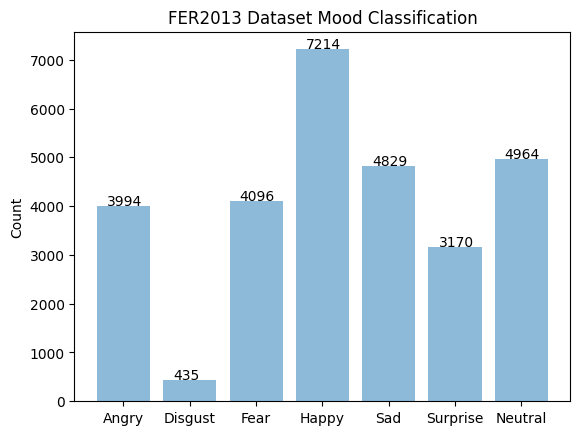

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

moods = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
y_pos = numpy.arange(len(moods))

counts = []
for label in range(len(moods)):
    label_str = str(label)
    count = moods_count[label_str]
    counts.append(count)
    plt.text(label - 0.25, count + 15, str(count))

# Draw histogram
plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, moods)
plt.ylabel('Count')
plt.title('FER2013 Dataset Mood Classification')

plt.show()

Label is: 0


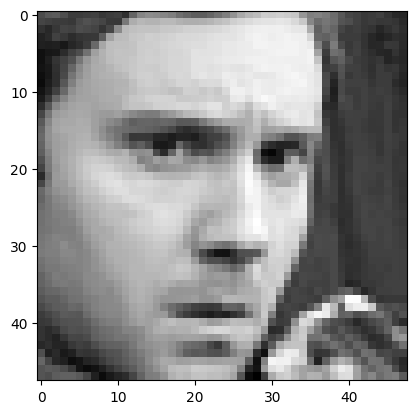

In [62]:
image = x_train[0]
label = y_train[0]

print('Label is: ' + str(label))
plt.imshow(image, cmap='gray')

In [63]:
from sklearn.model_selection import train_test_split

# Split dataset into train set and test set
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(len(x_train), 48, 48, 1)
x_test = x_test.reshape(len(x_test), 48, 48, 1)

print(x_train.shape)
print(x_test.shape)

(22967, 48, 48, 1)
(5742, 48, 48, 1)


In [64]:
%tensorflow_version 2.x
import tensorflow as tf

print('Tensorflow version: {}'.format(tf.__version__))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras import Model, Input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version: 2.12.0


In [65]:
facial_model = Sequential()

# 1st convolution layer
facial_model.add(Conv2D(64, input_shape=(48, 48, 1), kernel_size=(3, 3), activation='relu'))
facial_model.add(BatchNormalization())
facial_model.add(Conv2D(64, padding='same', kernel_size=(3, 3), activation='relu'))
facial_model.add(BatchNormalization())
facial_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
facial_model.add(Dropout(0.3))

# 2nd convolution layer
facial_model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
facial_model.add(BatchNormalization())
facial_model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
facial_model.add(BatchNormalization())
facial_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
facial_model.add(Dropout(0.3))

# 3rd convolution layer
facial_model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
facial_model.add(BatchNormalization())
facial_model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
facial_model.add(BatchNormalization())
facial_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
facial_model.add(Dropout(0.3))

# 4th convolution layer
facial_model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
facial_model.add(BatchNormalization())
facial_model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
facial_model.add(BatchNormalization())
facial_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
facial_model.add(Dropout(0.3))

# Fully connected layer
facial_model.add(Flatten())
facial_model.add(Dense(512, activation='relu'))
facial_model.add(Dropout(0.3))
facial_model.add(Dense(256, activation='relu'))
facial_model.add(Dropout(0.3))
facial_model.add(Dense(64, activation='relu'))
facial_model.add(Dropout(0.3))

facial_model.add(Dense(7, activation='softmax'))

# Compile the model
adam = Adam(learning_rate=0.001)
facial_model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Summary the model
facial_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 batch_normalization_16 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_17 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                      

In [66]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

# Train the model
history = facial_model.fit(x_train,
                        y_train,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
359/359 [==============================] - 28s 56ms/step - loss: 1.8824 - accuracy: 0.2335 - val_loss: 1.8219 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 2/100
359/359 [==============================] - 20s 55ms/step - loss: 1.7138 - accuracy: 0.3086 - val_loss: 1.6220 - val_accuracy: 0.3405 - lr: 0.0010
Epoch 3/100
359/359 [==============================] - 20s 54ms/step - loss: 1.5411 - accuracy: 0.3856 - val_loss: 1.4669 - val_accuracy: 0.3988 - lr: 0.0010
Epoch 4/100
359/359 [==============================] - 19s 54ms/step - loss: 1.4316 - accuracy: 0.4369 - val_loss: 1.5149 - val_accuracy: 0.4065 - lr: 0.0010
Epoch 5/100
359/359 [==============================] - 19s 54ms/step - loss: 1.3678 - accuracy: 0.4714 - val_loss: 1.3915 - val_accuracy: 0.4671 - lr: 0.0010
Epoch 6/100
359/359 [==============================] - 19s 53ms/step - loss: 1.3062 - accuracy: 0.5035 - val_loss: 1.3024 - val_accuracy: 0.5037 - lr: 0.0010
Epoch 7/100
359/359 [==============================]

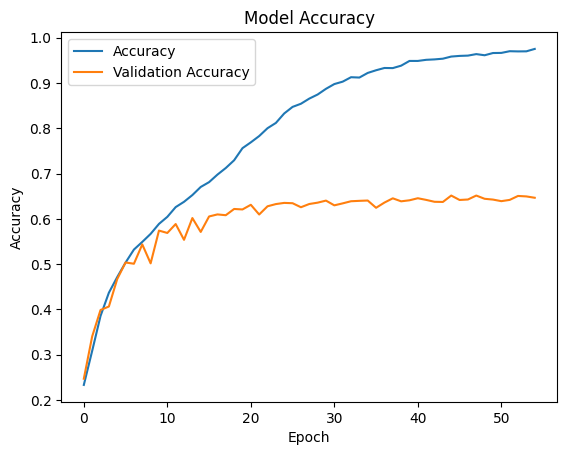

In [67]:
# Show accuracy diagram
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.show()

In [68]:
# Evaluate the model before improvement
_, score_before_improvement = facial_model.evaluate(x_test, y_test)
print('Score before improvement: {:.2%}'.format(score_before_improvement))

180/180 [==============================] - 2s 9ms/step - loss: 2.3235 - accuracy: 0.6465
Score before improvement: 64.65%


In [69]:
# Generate hard data
hard_images = []
hard_labels = []

# Make predictions
predictions = facial_model.predict(x_test)
for i, v in enumerate(predictions):
    y_predict = numpy.argmax(v)
    y_real = y_train[i]
    if y_predict != y_real:
        # If predict incorrectly, append to array
        image = x_train[i]
        hard_image = image.reshape(1, 48, 48, 1)
        hard_images.append(image)
        hard_labels.append(y_real)

x_hard = numpy.array(hard_images)
y_hard = numpy.array(hard_labels)

print(x_hard.shape)
print(y_hard.shape)


180/180 [==============================] - 1s 7ms/step
(4753, 48, 48, 1)
(4753,)


In [70]:
# Train the model on hard data
x_hard_train, x_hard_test, y_hard_train, y_hard_test = train_test_split(x_hard, y_hard, test_size=0.2)
history = facial_model.fit(x_hard_train,
                        y_hard_train,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_hard_test, y_hard_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
60/60 [==============================] - 4s 70ms/step - loss: 0.0723 - accuracy: 0.9782 - val_loss: 0.0142 - val_accuracy: 0.9947 - lr: 4.3047e-04
Epoch 2/100
60/60 [==============================] - 3s 54ms/step - loss: 0.0744 - accuracy: 0.9769 - val_loss: 0.0094 - val_accuracy: 0.9968 - lr: 4.3047e-04
Epoch 3/100
60/60 [==============================] - 3s 52ms/step - loss: 0.0655 - accuracy: 0.9792 - val_loss: 0.0131 - val_accuracy: 0.9947 - lr: 4.3047e-04
Epoch 4/100
60/60 [==============================] - 3s 54ms/step - loss: 0.0574 - accuracy: 0.9808 - val_loss: 0.0105 - val_accuracy: 0.9979 - lr: 4.3047e-04
Epoch 5/100
60/60 [==============================] - 3s 54ms/step - loss: 0.0295 - accuracy: 0.9890 - val_loss: 0.0094 - val_accuracy: 0.9979 - lr: 4.3047e-04
Epoch 6/100
60/60 [==============================] - 3s 56ms/step - loss: 0.0528 - accuracy: 0.9858 - val_loss: 0.0168 - val_accuracy: 0.9958 - lr: 4.3047e-04
Epoch 7/100
60/60 [===========================

In [71]:
# Perform data augmentation
data_generator = ImageDataGenerator(featurewise_center=False,
                                    featurewise_std_normalization=False,
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=.1,
                                    horizontal_flip=True)
flow = data_generator.flow(x_train, 
                           y_train, 
                           batch_size=64)

# Train the model again to balance out
history = facial_model.fit(flow,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
359/359 [==============================] - 21s 56ms/step - loss: 1.0783 - accuracy: 0.6476 - val_loss: 0.9843 - val_accuracy: 0.6452 - lr: 3.4868e-04
Epoch 2/100
359/359 [==============================] - 21s 60ms/step - loss: 0.9691 - accuracy: 0.6742 - val_loss: 0.9746 - val_accuracy: 0.6505 - lr: 3.4868e-04
Epoch 3/100
359/359 [==============================] - 20s 57ms/step - loss: 0.9443 - accuracy: 0.6744 - val_loss: 0.9551 - val_accuracy: 0.6597 - lr: 3.4868e-04
Epoch 4/100
359/359 [==============================] - 22s 62ms/step - loss: 0.9192 - accuracy: 0.6808 - val_loss: 0.9427 - val_accuracy: 0.6562 - lr: 3.4868e-04
Epoch 5/100
359/359 [==============================] - 21s 60ms/step - loss: 0.9051 - accuracy: 0.6850 - val_loss: 0.9457 - val_accuracy: 0.6585 - lr: 3.4868e-04
Epoch 6/100
359/359 [==============================] - 22s 61ms/step - loss: 0.8931 - accuracy: 0.6903 - val_loss: 0.9434 - val_accuracy: 0.6581 - lr: 3.4868e-04
Epoch 7/100
359/359 [=======

In [72]:
# Evaluate the model after improvement
_, score_after_improvement = facial_model.evaluate(x_test, y_test)
print('Score after improvement: {:.2%}'.format(score_after_improvement))

180/180 [==============================] - 2s 8ms/step - loss: 0.9816 - accuracy: 0.6672
Score after improvement: 66.72%


180/180 [==============================] - 1s 7ms/step


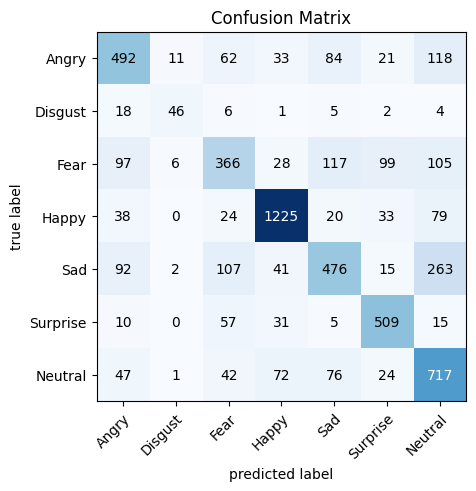

In [73]:
!pip install -U mlxtend > /dev/null 2>&1

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Make predictions
predictions = facial_model.predict(x_test)
y_predict = numpy.argmax(predictions, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)

# Display confusion matrix
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, class_names=class_names)
plt.title('Confusion Matrix')
plt.show()

In [74]:
from google.colab import files
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  # Upload JPG file from computer
  uploaded = files.upload()
  if len(uploaded) > 0:
    img_bytes = uploaded[list(uploaded.keys())[0]]
    with open(filename, 'wb') as f:
      f.write(img_bytes)
    return filename
  else:
    return None

In [96]:
take_photo()

Saving suprised-man.webp to suprised-man.webp


'photo.jpg'

In [97]:
from tensorflow.keras.preprocessing import image

def predict_facial_expression(image_path):
    """Predict facial expression for image"""
    # Open image
    rgb_image = image.load_img(path=image_path,
                            color_mode='grayscale',
                            target_size=(48, 48))
    # Convert to array
    rgb_array = image.img_to_array(rgb_image)
    rgb_array = numpy.expand_dims(rgb_array, axis=0)

    # Show image
    rgb_display = numpy.array(rgb_array, 'float32')
    rgb_display = rgb_display.reshape([48, 48]);
    plt.imshow(rgb_display, cmap='gray')
    plt.show()

    # Make predictions
    rgb_array = rgb_array / 255.0
    prediction = facial_model.predict(rgb_array)

    # Draw the histogram
    plt.bar(y_pos, prediction[0], align='center', alpha=0.5)
    plt.xticks(y_pos, moods)
    plt.ylabel('Percentage')
    plt.title('Facial Expression Prediction')
    plt.show()

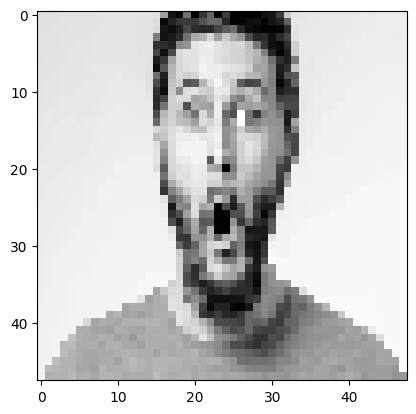

1/1 [==============================] - 0s 96ms/step


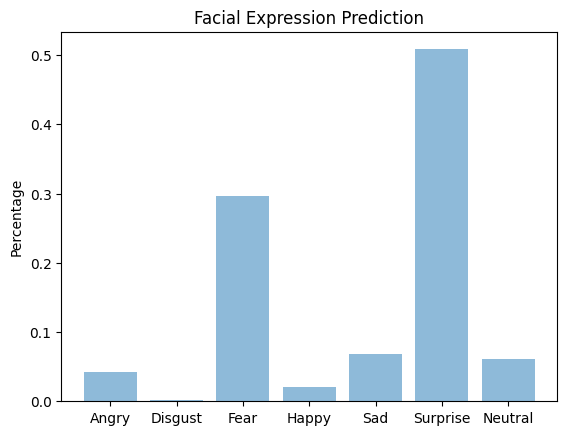

In [98]:
predict_facial_expression('photo.jpg')

In [99]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Saving the model to Google Drive
save_path = '/content/drive/MyDrive/Trained_Facial_Recognition_Model/Tensorflow_Model_V2/facial_recognition_model.h5'
facial_model.save(save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
import tensorflow as tf

# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(facial_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with tf.io.gfile.GFile('/content/drive/MyDrive/Trained_Facial_Recognition_Model/Tensorflow_Lite_Model_V2/facial_recognition_model.tflite', 'wb') as f:
    f.write(tflite_model)